In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings("ignore")

In [2]:
# Load dataset
file_path = "/content/updated_two_wheeler_ev_data_50k.csv"
df = pd.read_csv(file_path)


In [3]:

# Convert timestamp to datetime & extract time features
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month

# Feature Engineering
df["battery_usage_per_km"] = (df["starting_soc"] - df["ending_soc"]) / df["distance_km"]
df["total_energy_consumed"] = df["wh_per_km"] * df["distance_km"]

# Label Encoding for categorical variables
label_encoders = {}
for col in ["height_range", "weight_range", "wind_direction", "weather"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save for inverse transformation if needed

# Drop unnecessary columns
df.drop(["timestamp", "starting_point", "destination_point"], axis=1, inplace=True)

# Define features (X) and target (y)
X = df.drop(["ending_soc"], axis=1)
y = df["ending_soc"]

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 7, 10],  # Depth of trees
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Subsampling data
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Features per tree
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction
}

# Initialize model
xgb = XGBRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid,
                                   n_iter=20, scoring='neg_mean_squared_error',
                                   cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
print("Best Parameters:", random_search.best_params_)

# Train the best model
best_xgb_model = random_search.best_estimator_
best_xgb_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_best_xgb = best_xgb_model.predict(X_test_scaled)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


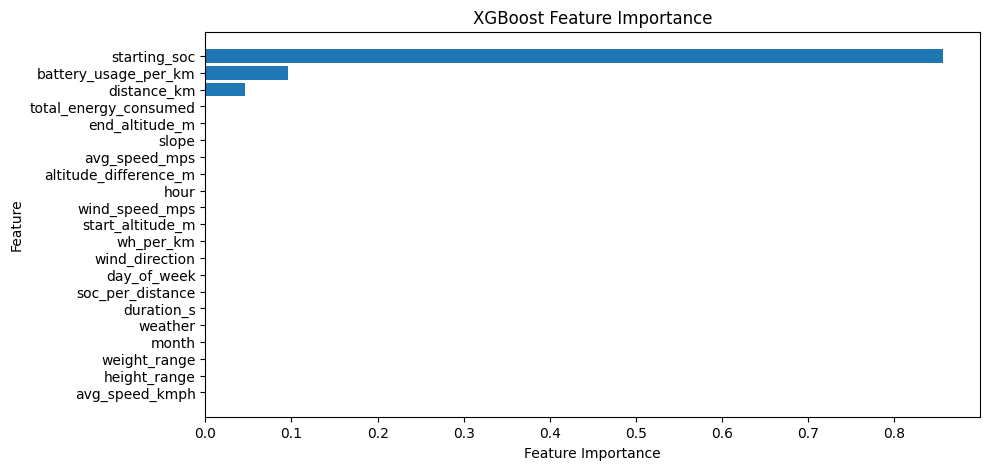

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = best_xgb_model.feature_importances_

# Convert to DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()


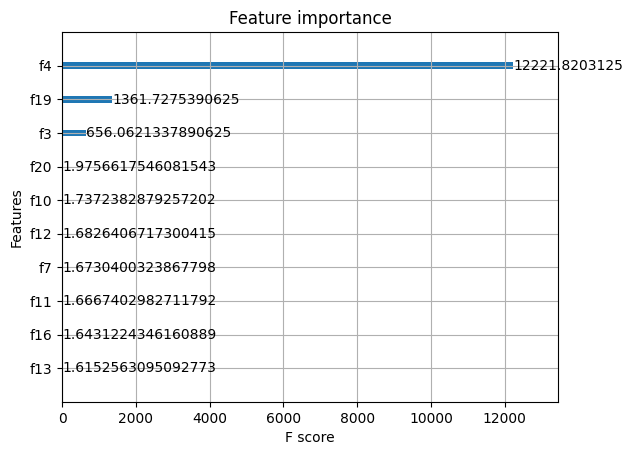

In [7]:
from xgboost import plot_importance

plot_importance(best_xgb_model, importance_type='gain', max_num_features=10)
plt.show()


In [8]:
# Get importance scores for Gain, Cover, and Weight
importance_types = ['weight', 'gain', 'cover']

for imp in importance_types:
    print(f"\nFeature Importance ({imp}):")
    print(best_xgb_model.get_booster().get_score(importance_type=imp))



Feature Importance (weight):
{'f0': 1723.0, 'f1': 1639.0, 'f2': 3765.0, 'f3': 7845.0, 'f4': 5674.0, 'f5': 2632.0, 'f6': 2255.0, 'f7': 3059.0, 'f9': 2221.0, 'f10': 1775.0, 'f11': 1555.0, 'f12': 2130.0, 'f13': 2866.0, 'f14': 1122.0, 'f15': 831.0, 'f16': 1878.0, 'f17': 1069.0, 'f18': 1441.0, 'f19': 8692.0, 'f20': 1902.0}

Feature Importance (gain):
{'f0': 0.6520005464553833, 'f1': 1.0845065116882324, 'f2': 1.3889869451522827, 'f3': 656.0621337890625, 'f4': 12221.8203125, 'f5': 1.4536654949188232, 'f6': 1.5187498331069946, 'f7': 1.6730400323867798, 'f9': 1.5890802145004272, 'f10': 1.7372382879257202, 'f11': 1.6667402982711792, 'f12': 1.6826406717300415, 'f13': 1.6152563095092773, 'f14': 1.504599928855896, 'f15': 1.2760484218597412, 'f16': 1.6431224346160889, 'f17': 1.4745659828186035, 'f18': 1.2448087930679321, 'f19': 1361.7275390625, 'f20': 1.9756617546081543}

Feature Importance (cover):
{'f0': 365.7051696777344, 'f1': 636.3428955078125, 'f2': 1389.088134765625, 'f3': 2098.361083984375,

In [9]:
from xgboost import XGBRegressor

# Use best hyperparameters from tuning
xgb_model = XGBRegressor(
    n_estimators=500,         # Increased from 100 → better learning
    learning_rate=0.1,        # Found optimal in tuning
    max_depth=7,              # Controls tree depth (prevents overfitting)
    gamma=0,                  # No pruning required as per tuning
    colsample_bytree=1.0,     # Uses all features per tree
    subsample=0.8,            # Uses 80% of data per tree to avoid overfitting
    random_state=42
)

# Train XGBoost
xgb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

print("XGBoost model trained with best hyperparameters and predictions generated.")


XGBoost model trained with best hyperparameters and predictions generated.


In [10]:
import pandas as pd

# Convert NumPy array back to DataFrame with correct column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)  # Use X_train.columns for consistency

# Get the correct feature names from your dataset
feature_names = X_train.columns.tolist()

# XGBoost outputs features as f0, f1, f2, ... → Convert them to actual names
feature_mapping = {f"f{i}": feature_names[i] for i in range(len(feature_names))}

# Low-importance features from XGBoost (map them to actual column names)
low_importance_features = ['f15', 'f17', 'f18','f14']
low_importance_columns = [feature_mapping[f] for f in low_importance_features if f in feature_mapping]

# Drop low-importance features
X_train_selected = X_train_scaled_df.drop(columns=low_importance_columns, axis=1)
X_test_selected = X_test_scaled_df.drop(columns=low_importance_columns, axis=1)

# Train XGBoost again on selected features
xgb_model.fit(X_train_selected, y_train)
y_pred_xgb = xgb_model.predict(X_test_selected)

# Print updated results
print("XGBoost retrained with selected features.")


XGBoost retrained with selected features.


In [20]:
import joblib

# Save the trained XGBoost model
joblib.dump(best_xgb_model, "xgboost_ev_model.pkl")

['xgboost_ev_model.pkl']

In [21]:
from google.colab import files
files.download("xgboost_ev_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0651 - mae: 0.2072 - val_loss: 0.0482 - val_mae: 0.1846
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0501 - mae: 0.1878 - val_loss: 0.0478 - val_mae: 0.1839
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0494 - mae: 0.1866 - val_loss: 0.0478 - val_mae: 0.1840
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0492 - mae: 0.1863 - val_loss: 0.0477 - val_mae: 0.1838
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0490 - mae: 0.1855 - val_loss: 0.0482 - val_mae: 0.1846
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0489 - mae: 0.1855 - val_loss: 0.0478 - val_mae: 0.1840
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0488 - mae: 0.1854 - val_loss: 0.0478 - val_mae: 0.1841
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0488 - mae: 0.1852 - val_loss: 0.0480 - val_mae: 0.1843
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - 

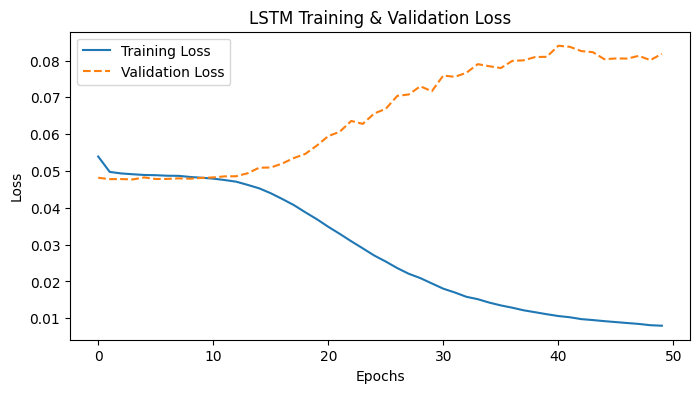

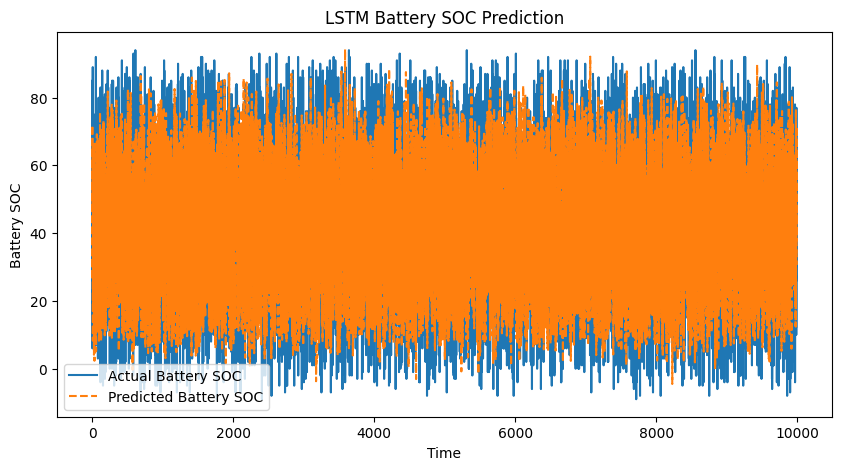

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reset index to ensure proper integer indexing
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Normalize target variable (Battery SOC)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Function to Create Time-Series Sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i: i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Define number of time steps (past records to look back)
TIME_STEPS = 10

# Reshape data for LSTM
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# Define LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(TIME_STEPS, X_train_scaled.shape[1])),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer (predicting `ending_soc`)
])

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile Model
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Train Model
history = model.fit(X_train_seq, y_train_seq,
                    validation_data=(X_test_seq, y_test_seq),
                    epochs=50, batch_size=64, verbose=1)

# Predict on Test Data
y_pred_lstm = model.predict(X_test_seq)

# Convert Predictions Back to Original Scale
y_pred_lstm = y_scaler.inverse_transform(y_pred_lstm)
y_test_seq_orig = y_scaler.inverse_transform(y_test_seq)

# Evaluate Model Performance
mae = mean_absolute_error(y_test_seq_orig, y_pred_lstm)
mse = mean_squared_error(y_test_seq_orig, y_pred_lstm)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_seq_orig, y_pred_lstm)

print(f"\n🔍 LSTM Model Performance:")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training & Validation Loss")
plt.legend()
plt.show()

# Plot Predictions vs Actual
plt.figure(figsize=(10,5))
plt.plot(y_test_seq_orig, label="Actual Battery SOC")
plt.plot(y_pred_lstm, label="Predicted Battery SOC", linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Battery SOC")
plt.legend()
plt.title("LSTM Battery SOC Prediction")
plt.show()


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

# Print evaluation results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.5177
Mean Squared Error (MSE): 0.5228
Root Mean Squared Error (RMSE): 0.7230
R² Score: 0.9990


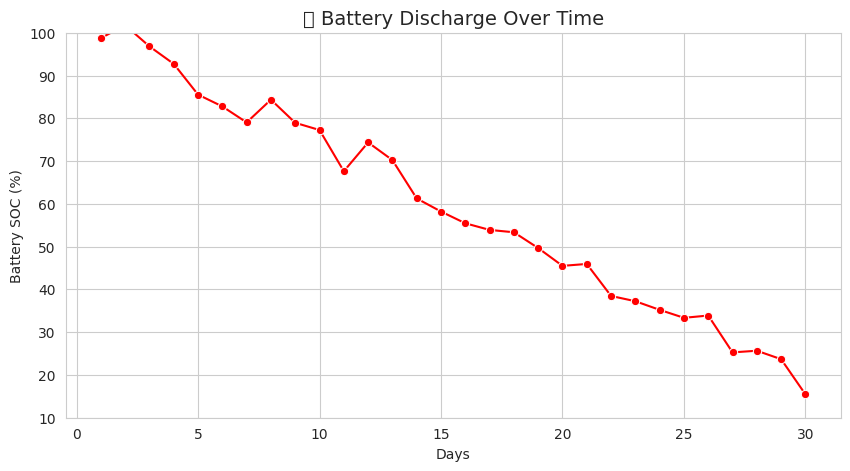

In [14]:

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulating Sample Data
np.random.seed(42)
days = np.arange(1, 31)  # 1 month of data
battery_soc = np.linspace(100, 20, num=30) + np.random.uniform(-5, 5, 30)  # Battery State of Charge %
battery_cycles = np.cumsum(np.random.randint(1, 5, 30))  # Charge cycles
battery_health = np.linspace(100, 85, num=30) + np.random.uniform(-2, 2, 30)  # Battery Health %
battery_usage = np.random.uniform(2, 10, 30)  # Energy usage in kWh
speed_distribution = np.random.normal(40, 10, 300)  # Speed Data (km/h)
weekly_distance = np.random.randint(50, 200, 4)  # Weekly travel distance in km

# Create a DataFrame
df = pd.DataFrame({
    "Day": days,
    "Battery_SOC": battery_soc,
    "Battery_Cycles": battery_cycles,
    "Battery_Health": battery_health,
    "Energy_Usage": battery_usage
})

# Set seaborn style for better visualization
sns.set_style("whitegrid")

# Cell 1: Battery Discharge Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="Day", y="Battery_SOC", data=df, marker="o", color="red")
plt.title("🔋 Battery Discharge Over Time", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Battery SOC (%)")
plt.ylim(10, 100)
plt.show()


In [29]:
df.to_csv("sample_battery_data2.csv", index=False)

In [32]:
print(df_new.columns)

Index(['height_range', 'weight_range', 'duration_s', 'distance_km',
       'starting_soc', 'ending_soc', 'soc_per_distance', 'wh_per_km',
       'avg_speed_mps', 'avg_speed_kmph', 'start_altitude_m', 'end_altitude_m',
       'altitude_difference_m', 'slope', 'wind_speed_mps', 'wind_direction',
       'weather', 'hour', 'day_of_week', 'month', 'battery_usage_per_km',
       'total_energy_consumed', 'predicted_ending_soc'],
      dtype='object')


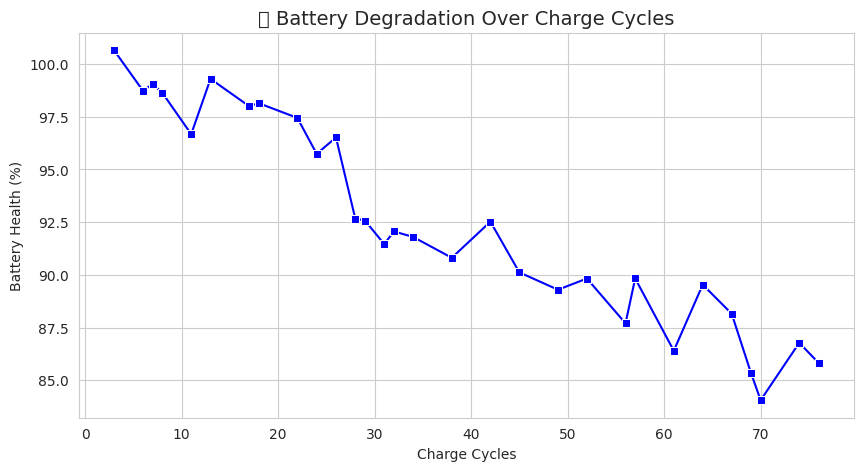

In [ ]:
# Cell 2: Battery Degradation Graph
plt.figure(figsize=(10, 5))
sns.lineplot(x="Battery_Cycles", y="Battery_Health", data=df, marker="s", color="blue")
plt.title("📉 Battery Degradation Over Charge Cycles", fontsize=14)
plt.xlabel("Charge Cycles")
plt.ylabel("Battery Health (%)")
plt.show()


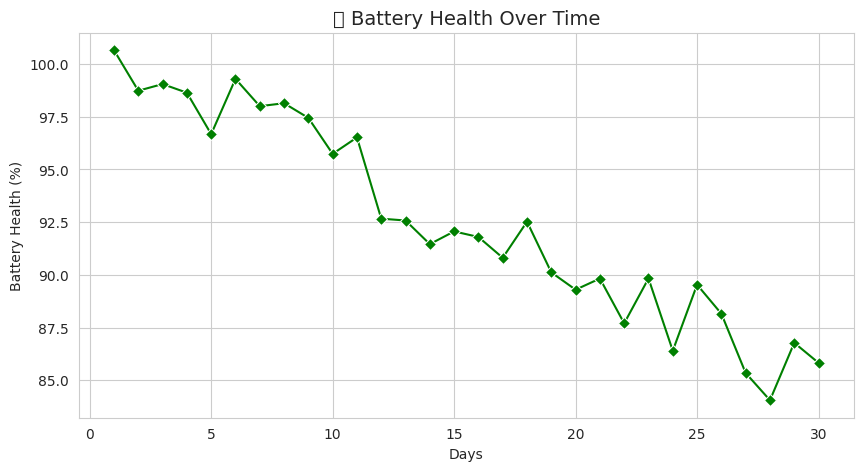

In [ ]:
# Cell 3: Battery Health Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(x="Day", y="Battery_Health", data=df, marker="D", color="green")
plt.title("📊 Battery Health Over Time", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Battery Health (%)")
plt.show()

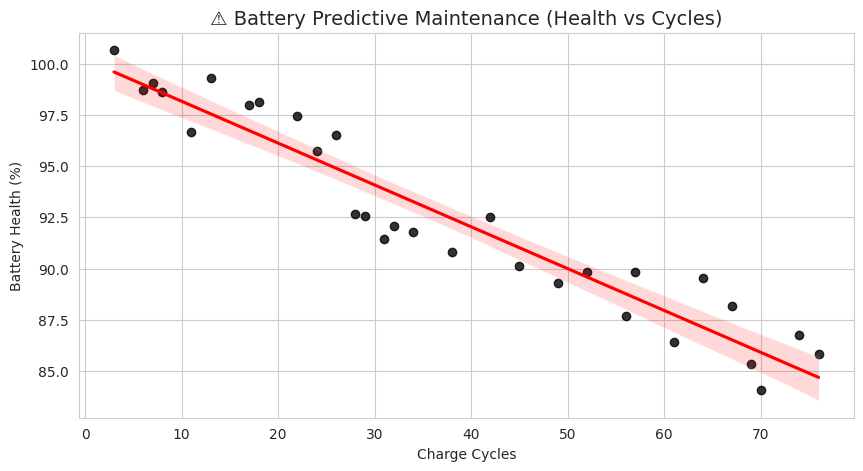

In [ ]:
# Cell 4: Battery Predictive Maintenance
plt.figure(figsize=(10, 5))
sns.regplot(x="Battery_Cycles", y="Battery_Health", data=df, scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.title("⚠️ Battery Predictive Maintenance (Health vs Cycles)", fontsize=14)
plt.xlabel("Charge Cycles")
plt.ylabel("Battery Health (%)")
plt.show()


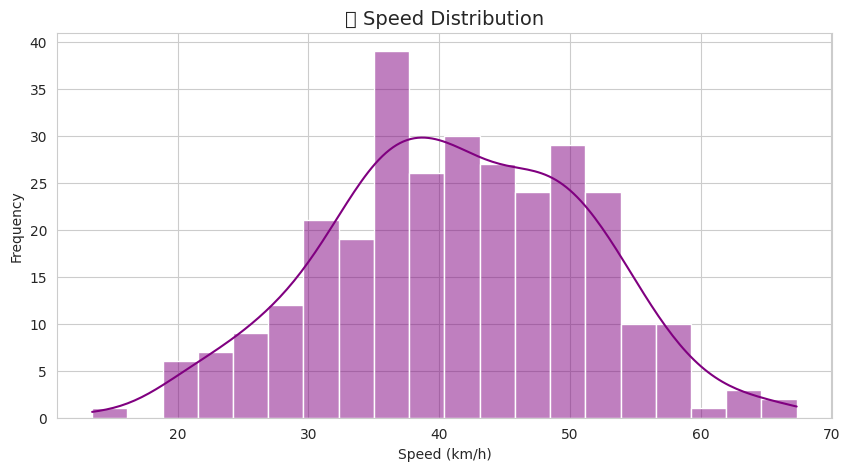

In [ ]:
# Cell 5: Speed Distribution Histogram
plt.figure(figsize=(10, 5))
sns.histplot(speed_distribution, bins=20, kde=True, color="purple")
plt.title("🚀 Speed Distribution", fontsize=14)
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.show()


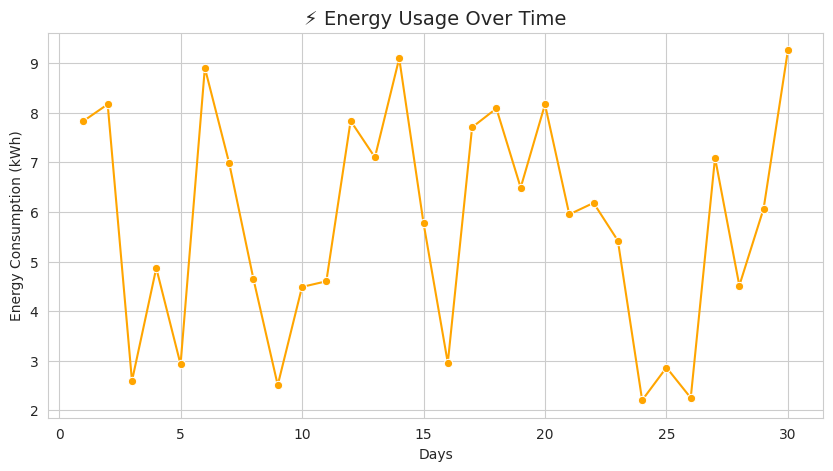

In [ ]:
# Cell 6: Energy Usage Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(x="Day", y="Energy_Usage", data=df, marker="o", color="orange")
plt.title("⚡ Energy Usage Over Time", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Energy Consumption (kWh)")
plt.show()


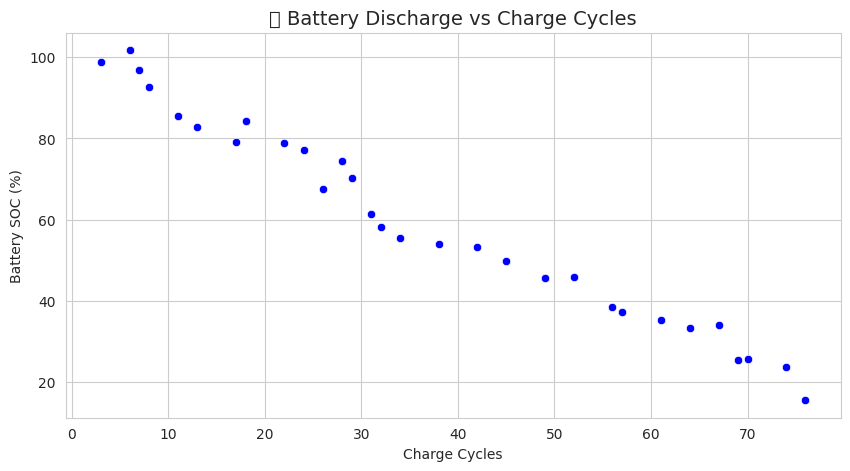

In [ ]:
# Cell 7: Battery Discharge Scatter Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x="Battery_Cycles", y="Battery_SOC", data=df, color="blue")
plt.title("🔋 Battery Discharge vs Charge Cycles", fontsize=14)
plt.xlabel("Charge Cycles")
plt.ylabel("Battery SOC (%)")
plt.show()


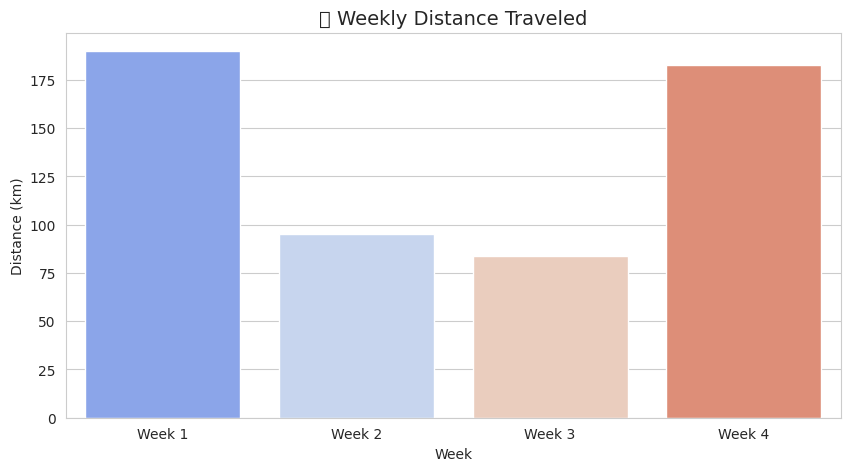

In [ ]:
# Cell 8: Weekly Distance Traveled
plt.figure(figsize=(10, 5))
sns.barplot(x=["Week 1", "Week 2", "Week 3", "Week 4"], y=weekly_distance, palette="coolwarm")
plt.title("🛣️ Weekly Distance Traveled", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Distance (km)")
plt.show()


**XGBOOST BASED PREDICTIONS**

In [17]:
# import pandas as pd
# import numpy as np

# # Set random seed for reproducibility
# np.random.seed(42)

# # Function to generate synthetic EV dataset
# def generate_synthetic_ev_data(n_samples=50):
#     timestamps = pd.date_range(start="2025-03-01 00:00", periods=n_samples, freq="H").strftime("%d-%m-%Y %H:%M")

#     height_range = np.random.choice(["150-160", "160-170", "170-180", "180-190"], n_samples)
#     weight_range = np.random.choice(["40-50", "50-60", "60-70", "70-80", "80-90", "90-100"], n_samples)

#     starting_lat = np.random.uniform(53.3, 53.45, n_samples)
#     starting_lon = np.random.uniform(-6.3, -6.15, n_samples)
#     destination_lat = starting_lat + np.random.uniform(-0.02, 0.02, n_samples)
#     destination_lon = starting_lon + np.random.uniform(-0.02, 0.02, n_samples)

#     duration_s = np.random.randint(300, 4000, n_samples)
#     distance_km = np.random.uniform(1, 15, n_samples)
#     starting_soc = np.random.randint(30, 95, n_samples)
#     ending_soc = starting_soc - np.random.randint(5, 30, n_samples)

#     soc_per_distance = np.round(np.abs((starting_soc - ending_soc) / distance_km), 2)
#     wh_per_km = np.round(soc_per_distance * np.random.uniform(3, 5), 2)

#     avg_speed_mps = np.round(distance_km * 1000 / duration_s, 2)
#     avg_speed_kmph = np.round(avg_speed_mps * 3.6, 2)

#     start_altitude = np.random.randint(10, 140, n_samples)
#     end_altitude = start_altitude + np.random.randint(-20, 20, n_samples)
#     altitude_difference_m = end_altitude - start_altitude

#     slope = np.round(altitude_difference_m / distance_km, 5)

#     wind_speed_mps = np.round(np.random.uniform(3, 15, n_samples), 1)
#     wind_direction = np.random.choice(["N", "S", "E", "W", "NW", "NE", "SW", "SE"], n_samples)
#     weather = np.random.choice(["Dry", "Rainy", "Snowy", "Foggy", "Wet"], n_samples)

#     synthetic_data = pd.DataFrame({
#         "timestamp": timestamps,
#         "height_range": height_range,
#         "weight_range": weight_range,
#         "starting_point": [f"{lat},{lon}" for lat, lon in zip(starting_lat, starting_lon)],
#         "destination_point": [f"{lat},{lon}" for lat, lon in zip(destination_lat, destination_lon)],
#         "duration_s": duration_s,
#         "distance_km": np.round(distance_km, 2),
#         "starting_soc": starting_soc,
#         "ending_soc": ending_soc,
#         "soc_per_distance": soc_per_distance,
#         "wh_per_km": wh_per_km,
#         "avg_speed_mps": avg_speed_mps,
#         "avg_speed_kmph": avg_speed_kmph,
#         "start_altitude_m": start_altitude,
#         "end_altitude_m": end_altitude,
#         "altitude_difference_m": altitude_difference_m,
#         "slope": slope,
#         "wind_speed_mps": wind_speed_mps,
#         "wind_direction": wind_direction,
#         "weather": weather
#     })

#     return synthetic_data

# # Generate the synthetic dataset
# df = generate_synthetic_ev_data(50)

# # Save to CSV
# df.to_csv("synthetic_ev_data.csv", index=False)
# print("Synthetic dataset saved as 'synthetic_ev_data.csv'.")


Synthetic dataset saved as 'synthetic_ev_data.csv'.


In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the synthetic dataset
df = pd.read_csv("synthetic_ev_data.csv")

# Convert timestamp to datetime & extract time features
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M")
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month

# Feature Engineering
df["battery_usage_per_km"] = (df["starting_soc"] - df["ending_soc"]) / df["distance_km"]
df["total_energy_consumed"] = df["wh_per_km"] * df["distance_km"]

# Label Encoding for categorical variables
label_encoders = {}
for col in ["height_range", "weight_range", "wind_direction", "weather"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save for inverse transformation if needed

# Drop unnecessary columns
df.drop(["timestamp", "starting_point", "destination_point"], axis=1, inplace=True)

# Define features (X) and target (y)
X_new = df.drop(["ending_soc"], axis=1)
y_new = df["ending_soc"]

# Scale the data
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)


In [25]:
import joblib

# Load the saved XGBoost model
best_xgb_model = joblib.load("xgboost_ev_model.pkl")


In [26]:
# Predict ending_soc using the trained XGBoost model
y_pred_xgb = best_xgb_model.predict(X_new_scaled)

# Convert predictions to a DataFrame
df["predicted_ending_soc"] = y_pred_xgb


**SAMPLE DATA2**

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv("/content/sample_battery_data2.csv")

# Extract time-related features
df["hour"] = np.random.randint(0, 24, df.shape[0])
df["day_of_week"] = np.random.randint(0, 7, df.shape[0])
df["month"] = 3  # Assume March data

# Encoding categorical values
label_encoders = {}
for col in ["height_range", "weight_range", "wind_direction", "weather"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Selecting features (excluding 'ending_soc' as it's the target variable)
X_new = df.drop(["ending_soc", "predicted_ending_soc"], axis=1)

# Scaling features
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

print("✅ Preprocessing Complete! Data is ready for XGBoost prediction.")


✅ Preprocessing Complete! Data is ready for XGBoost prediction.


In [36]:
import joblib

# Load trained XGBoost model
best_xgb_model = joblib.load("xgboost_ev_model.pkl")

# Predict ending SOC
df["predicted_ending_soc"] = best_xgb_model.predict(X_new_scaled)

# Save Predictions
df.to_csv("ev_predictions.csv", index=False)

print("✅ Predictions saved to 'ev_predictions.csv'")


✅ Predictions saved to 'ev_predictions.csv'


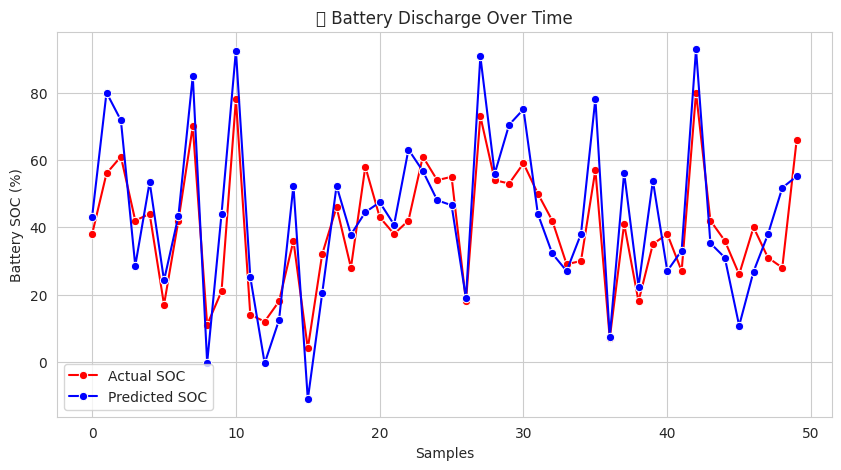

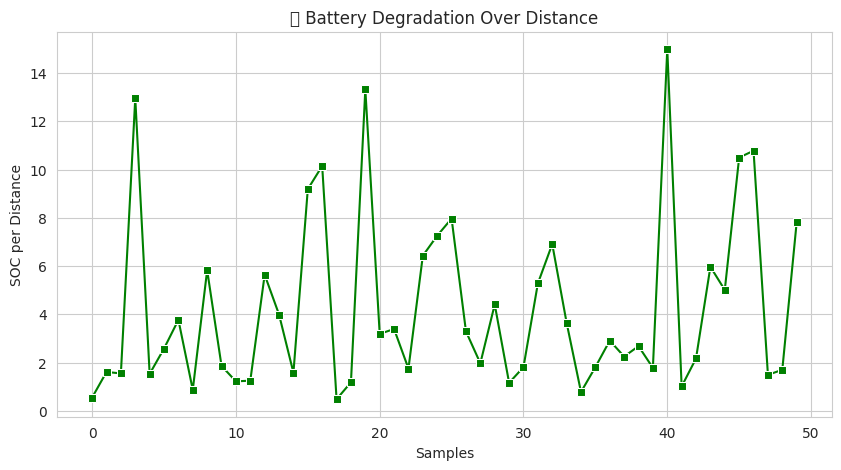

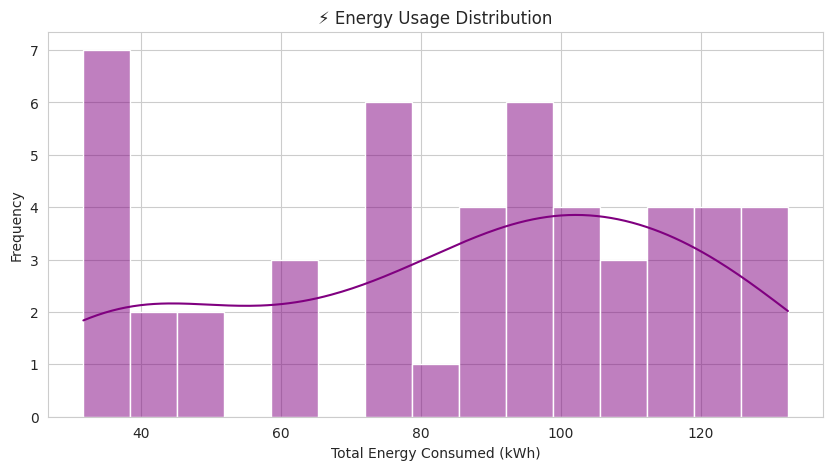

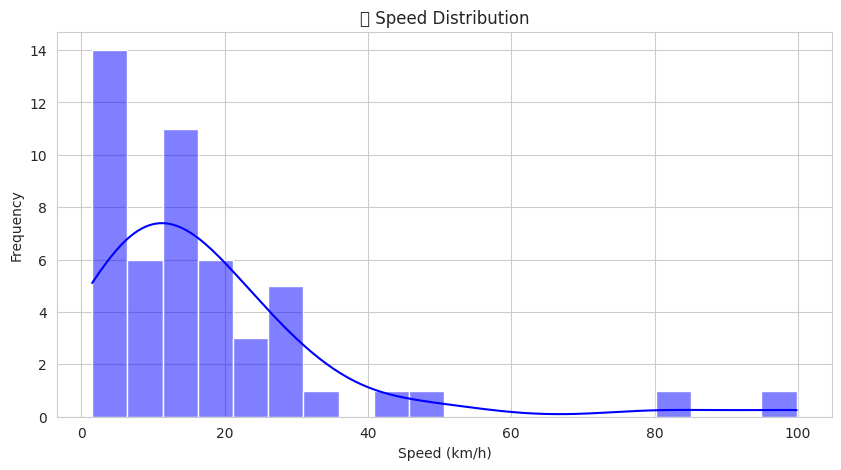

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 🔋 Battery Discharge Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y=df["ending_soc"], marker="o", color="red", label="Actual SOC")
sns.lineplot(x=df.index, y=df["predicted_ending_soc"], marker="o", color="blue", label="Predicted SOC")
plt.title("🔋 Battery Discharge Over Time")
plt.xlabel("Samples")
plt.ylabel("Battery SOC (%)")
plt.legend()
plt.show()

# 📉 Battery Health Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y=df["soc_per_distance"], marker="s", color="green")
plt.title("📉 Battery Degradation Over Distance")
plt.xlabel("Samples")
plt.ylabel("SOC per Distance")
plt.show()

# ⚡ Energy Usage Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["total_energy_consumed"], bins=15, kde=True, color="purple")
plt.title("⚡ Energy Usage Distribution")
plt.xlabel("Total Energy Consumed (kWh)")
plt.ylabel("Frequency")
plt.show()

# 🚗 Speed Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["avg_speed_kmph"], bins=20, kde=True, color="blue")
plt.title("🚗 Speed Distribution")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.show()


In [42]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load the EV Predictions dataset
df = pd.read_csv("ev_predictions.csv")

# Simulating battery charge cycles based on usage
df["battery_cycles"] = np.random.randint(200, 800, df.shape[0])  # Random charge cycles for now

# 1️⃣ Calculate Battery Health (%) - Assuming 0.05% degradation per cycle
df["battery_health"] = 100 - (df["battery_cycles"] * 0.05)
df["battery_health"] = df["battery_health"].clip(lower=50)  # Minimum health of 50% to avoid unrealistic values

# 2️⃣ Predict Next Maintenance Date
degradation_rate = (df["battery_health"].iloc[0] - df["battery_health"].iloc[-1]) / len(df)  # Daily health drop
days_to_maintenance = (df["battery_health"].iloc[-1] - 75) / degradation_rate  # Maintenance at 75% health

# Predicted Date for Maintenance
current_date = datetime.date.today()
predicted_maintenance_date = current_date + datetime.timedelta(days=round(days_to_maintenance))

# 3️⃣ Display Results
print(f"🔋 Estimated Battery Health: {df['battery_health'].iloc[-1]:.2f}%")
print(f"🛠️ Predicted Maintenance Date: {predicted_maintenance_date.strftime('%Y-%m-%d')}")




🔋 Estimated Battery Health: 73.85%
🛠️ Predicted Maintenance Date: 2025-03-11
